/tmp/ipykernel_27305/4067607730.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


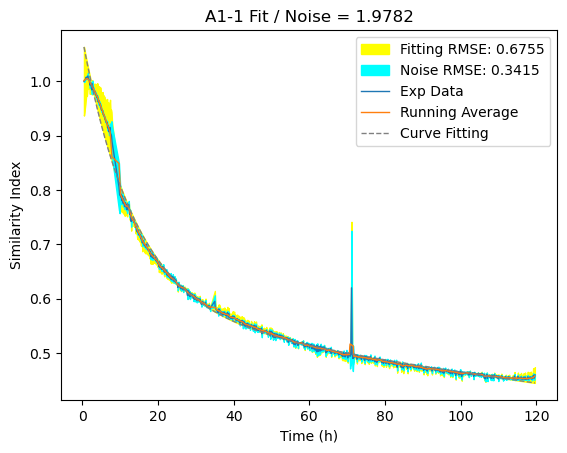

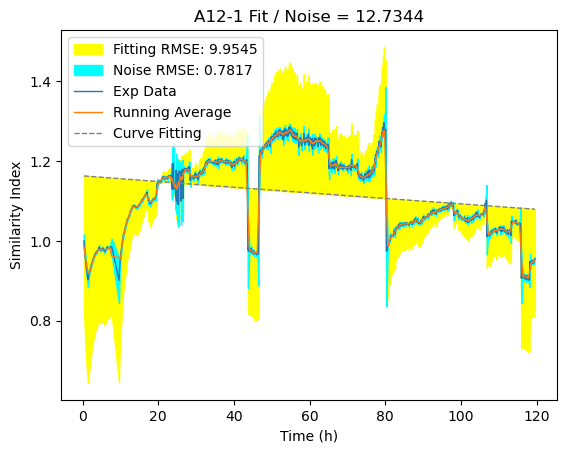

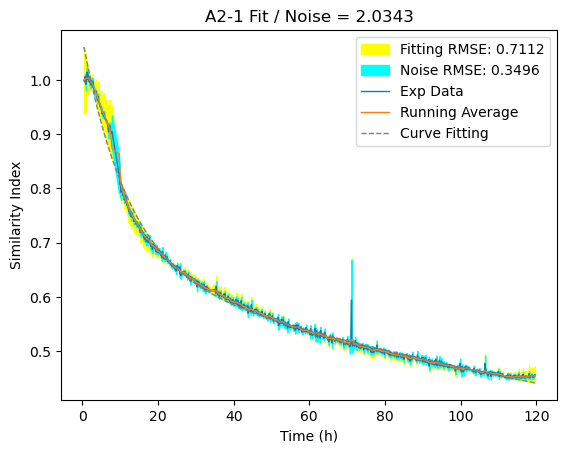

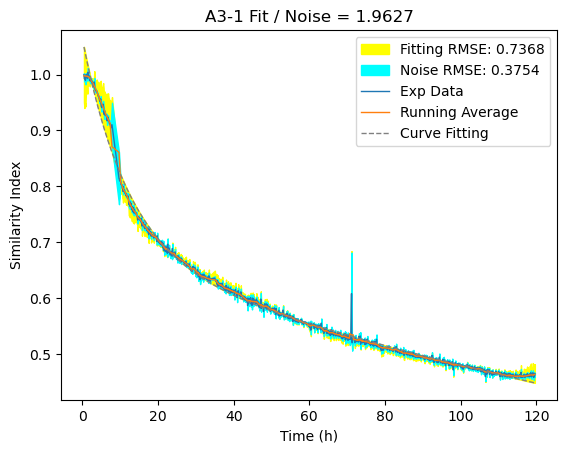

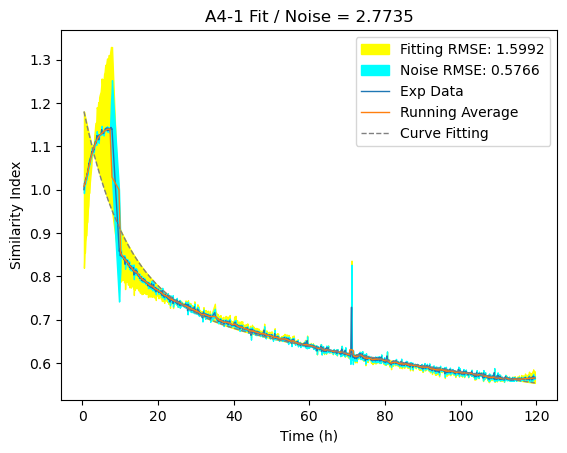

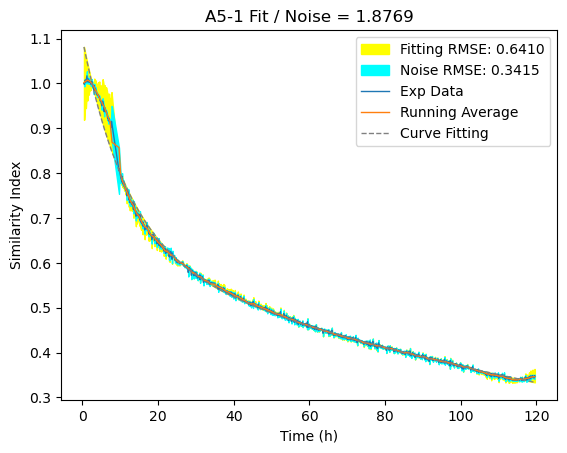

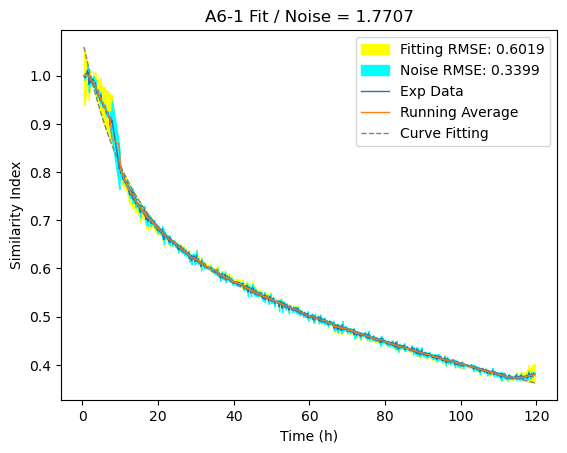

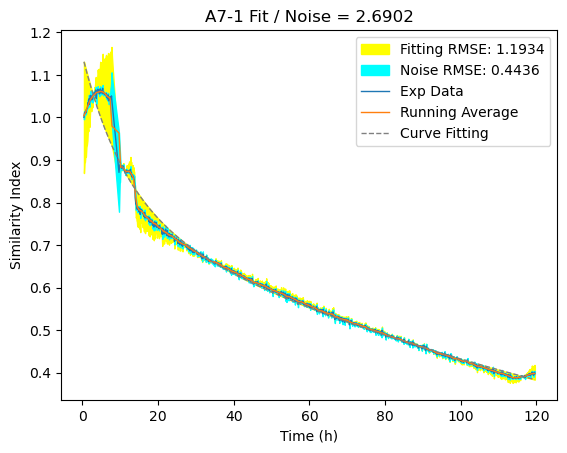

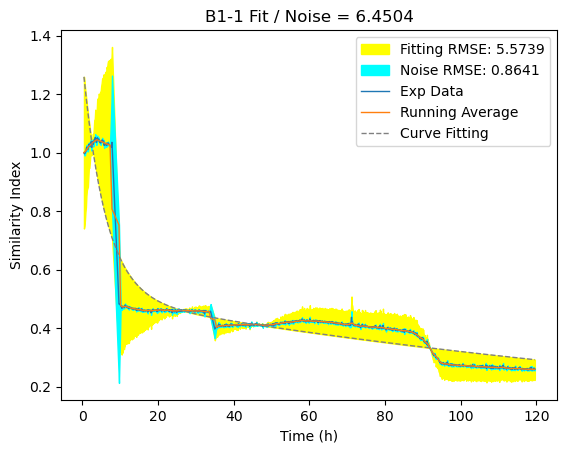

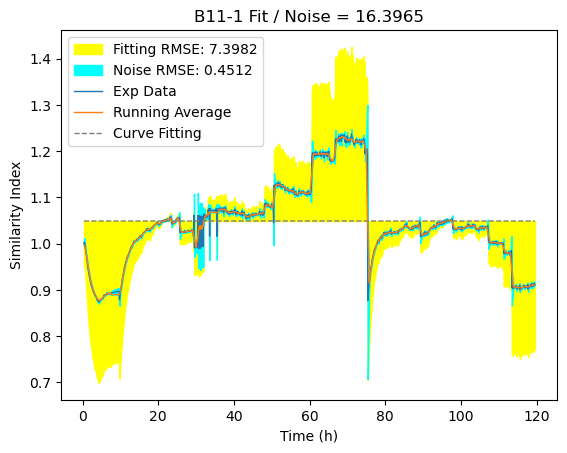

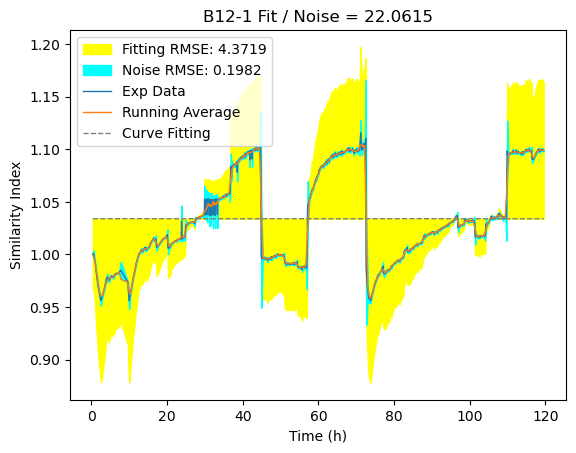

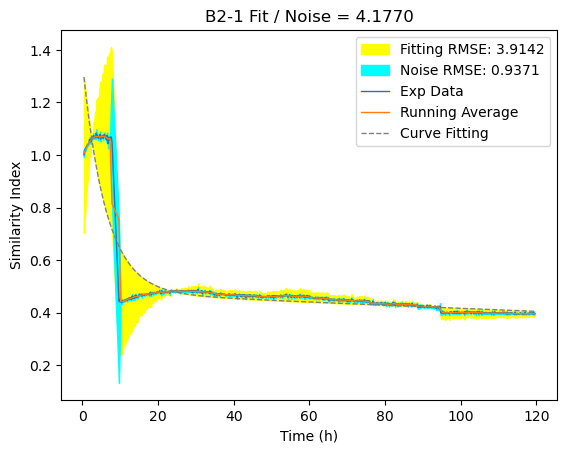

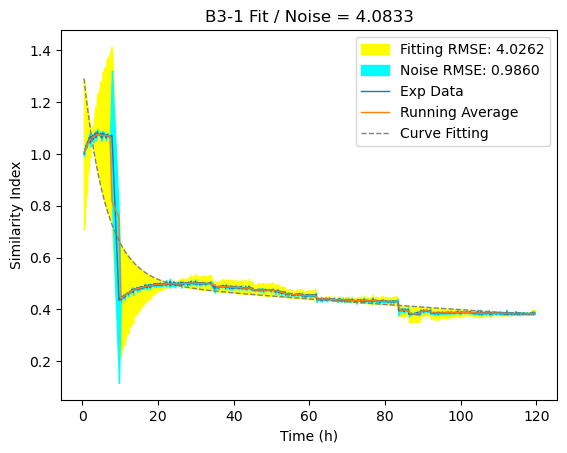

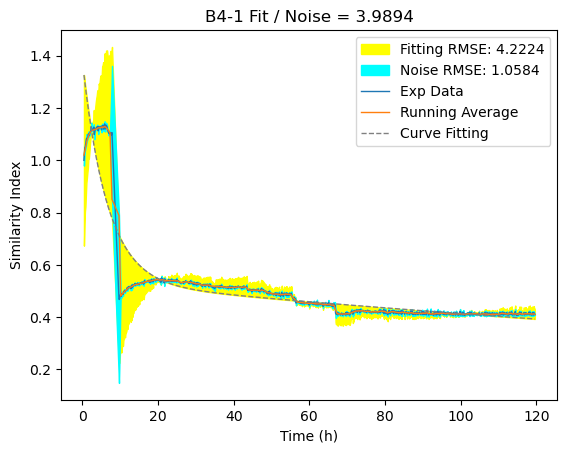

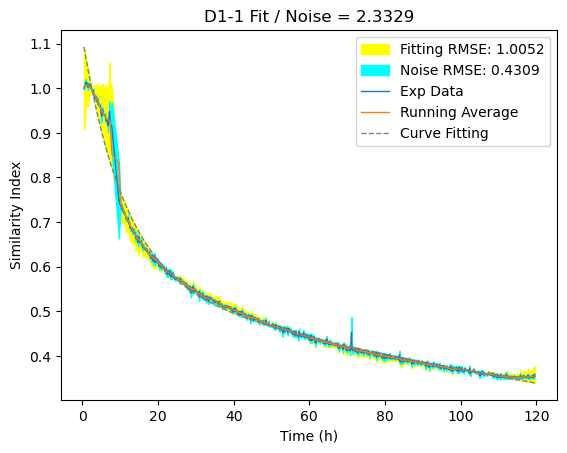

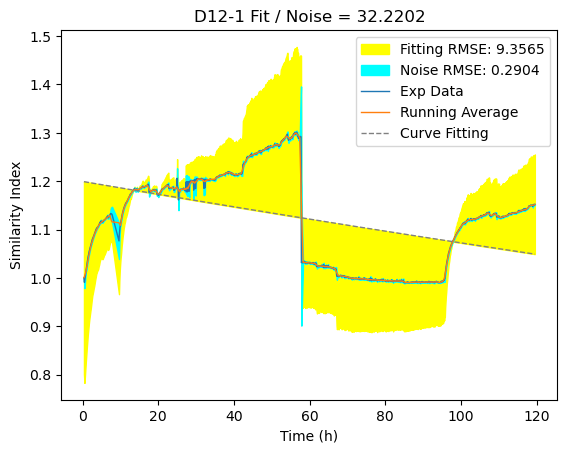

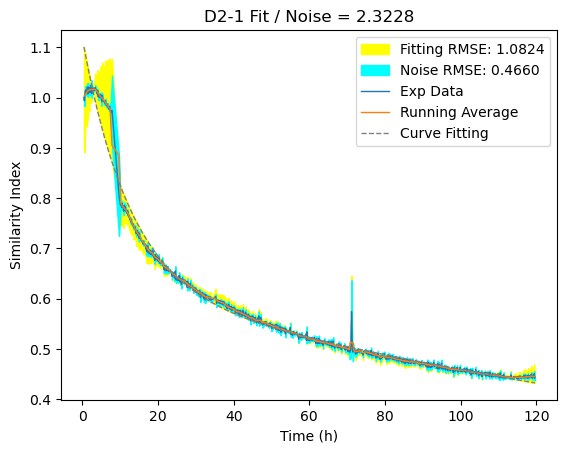

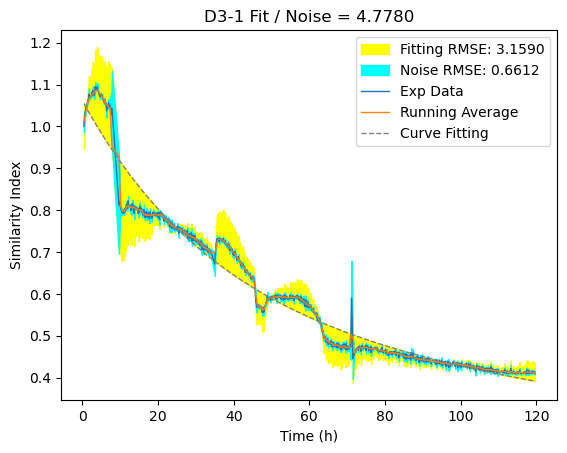

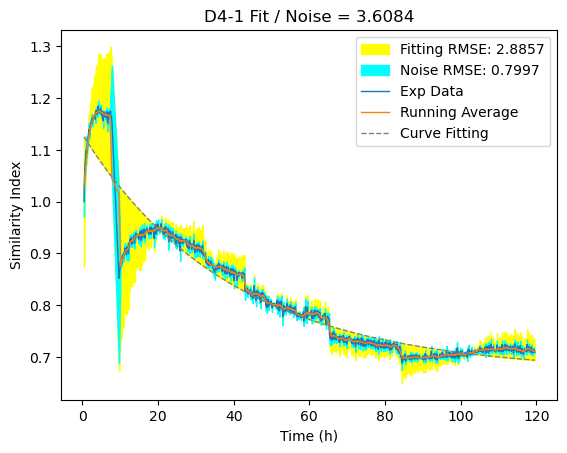

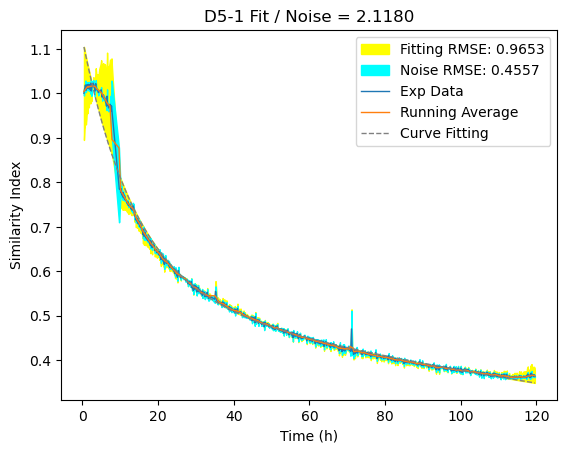

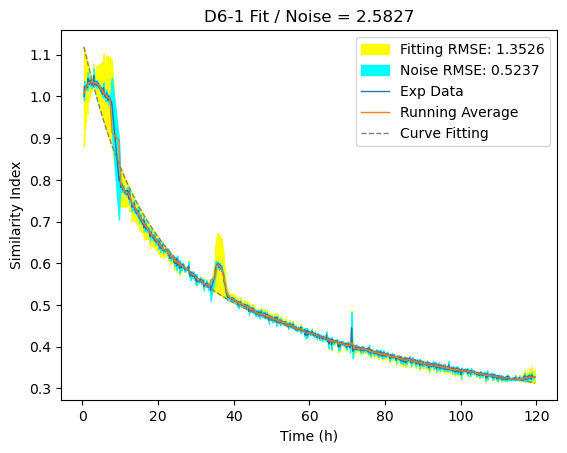

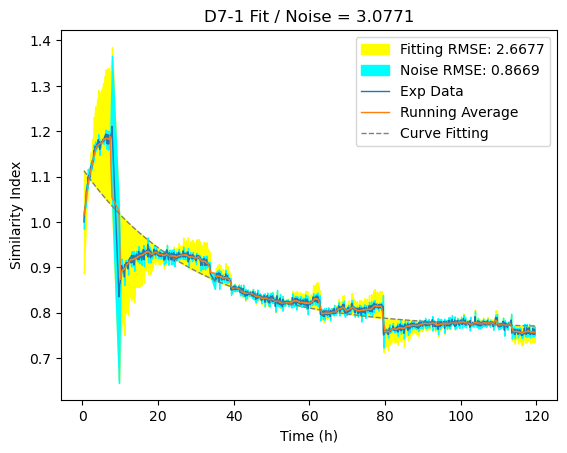

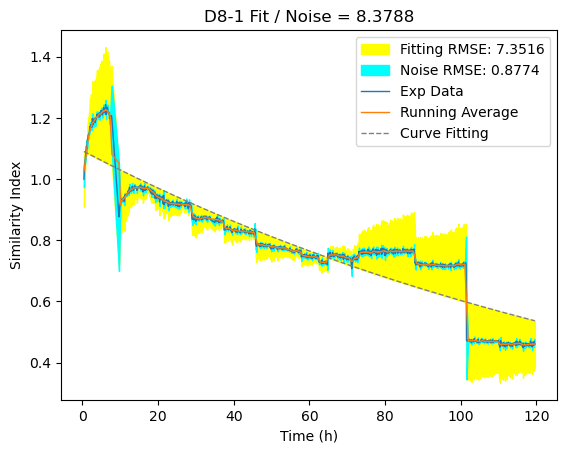

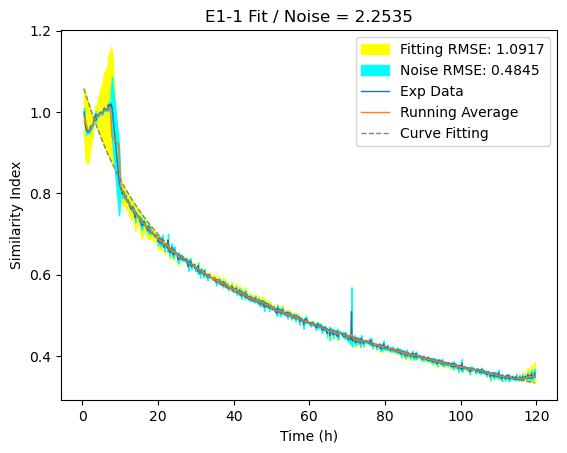

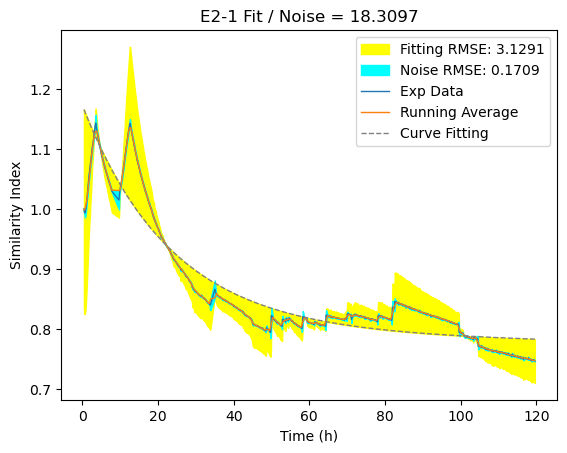

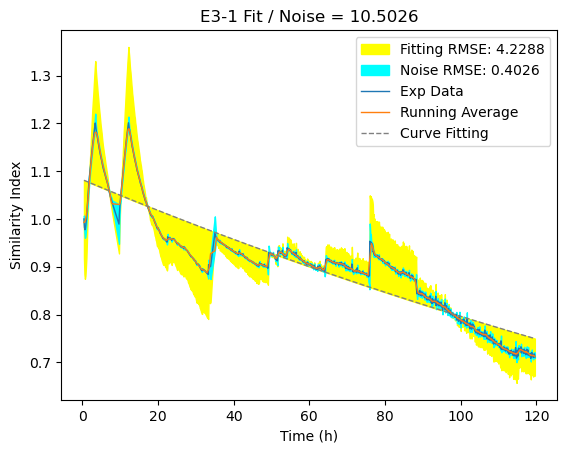

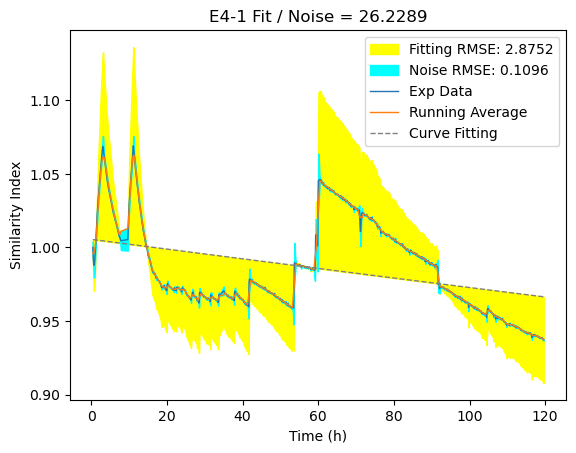

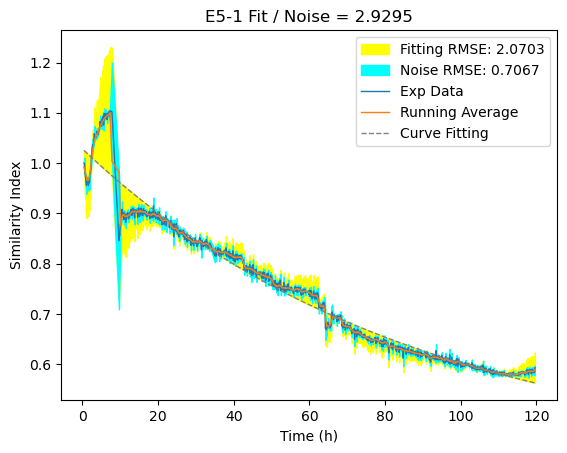

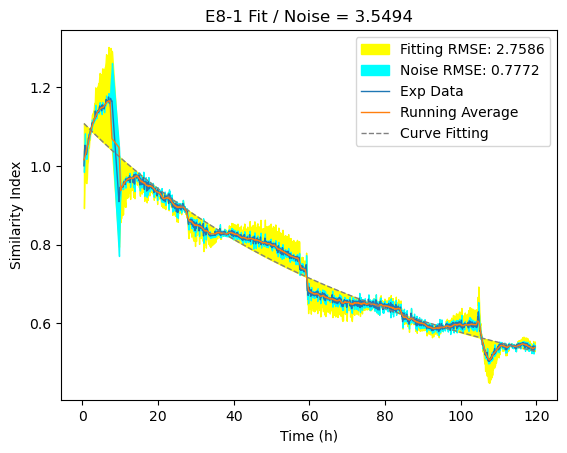

In [1]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def rmse_noise_fit(fpath, plot_fname=None, roll_window_size=10):
    well_name = os.path.split(fpath)[-1].replace(".csv", "")
    df = pd.read_csv(fpath, index_col=0)
    if len(df.columns) == 3:
        df.columns = ["time", "data", "yfit"]
        # Eli's fitting
        rmse_fit = np.abs((df["yfit"] - df["data"]).to_numpy())
        accum_rmse_fit = np.sum(rmse_fit*np.diff(df["time"], n=1, axis=0, prepend=df.at[0, "time"]))
        # padded running average
        # https://stackoverflow.com/questions/47484899/moving-average-produces-array-of-different-length
        N = roll_window_size
        y_padded = np.pad(df["data"], (N//2, N-1-N//2), mode='edge')
        y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid')
        rmse_noise = np.abs((y_smooth - df["data"]).to_numpy())
        accum_rmse_noise = np.sum(rmse_noise*np.diff(df["time"], n=1, axis=0, prepend=df.at[0, "time"]))

        # plot the graph if plot_fname is provided
        if type(plot_fname) != type(None):
            fig, ax = plt.subplots()
            ax.fill_between(df["time"], df["data"]-rmse_fit, df["data"]+rmse_fit, color="yellow", label="Fitting RMSE: " + "%.4f" % accum_rmse_fit)
            ax.fill_between(df["time"], df["data"]-rmse_noise, df["data"]+rmse_noise, color="cyan", label="Noise RMSE: " + "%.4f" % accum_rmse_noise)
            ax.plot(df["time"], df["data"], lw=1, label="Exp Data")
            ax.plot(df["time"], y_smooth, lw=1, label="Running Average")
            ax.plot(df["time"], df["yfit"], c="grey", ls="--", lw=1, label="Curve Fitting")
            ax.legend()
            ax.set_title(well_name + " Fit / Noise = " + "%.4f" % (accum_rmse_fit / accum_rmse_noise))
            ax.set_xlabel("Time (h)")
            ax.set_ylabel("Similarity Index")
            fig.savefig(plot_fname, dpi=320, transparent=True)
            #plt.close("all")
        return accum_rmse_fit, accum_rmse_noise
    else:
        return -1, -1

# plot all wells
dirname = "data"
fnames = [x for x in os.listdir(dirname) if x.endswith(".csv")]
for fname in fnames:
    fpath = os.path.join(dirname, fname)
    well_name = fname.replace(".csv", "")
    fit, noise = rmse_noise_fit(fpath, well_name + ".png", roll_window_size=10)